***Import all the libraries***

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from imblearn.over_sampling import SMOTE


***Add the dataset and convert the date format to integer type.***

In [2]:
train_df = pd.read_csv('../data/cases_train_processed.csv')
test_df = pd.read_csv('../data/cases_test_processed.csv')

# Some preprocessing
# convert date from object type to int type
train_df["date_confirmation"] = pd.to_datetime(train_df["date_confirmation"]).dt.strftime("%Y%m%d").astype(int) 
test_df["date_confirmation"] = pd.to_datetime(test_df["date_confirmation"]).dt.strftime("%Y%m%d").astype(int) 
# train_df2 = train_df.copy() # creating a copy for lightgbm because of different processing method
# test_df2 = test_df.copy() # creating a copy for lightgbm because of different processing method

In [4]:
#use label encoder to normalize categorical features in dataframe
le = LabelEncoder()
categoricalFeatures = ['sex', 'province', 'country','key','additional_information', 'source']
for feat in categoricalFeatures:
    train_df[feat]= le.fit_transform(train_df[feat])

In [5]:
train_df["outcome"].value_counts()

nonhospitalized    149990
hospitalized       125000
recovered           88137
deceased             4499
Name: outcome, dtype: int64

In [6]:
train_df.dtypes

age                       float64
sex                         int64
province                    int64
country                     int64
latitude_x                float64
longitude_x               float64
date_confirmation           int64
additional_information      int64
source                      int64
outcome                    object
key                         int64
latitude_y                float64
longitude_y               float64
confirmed_sum             float64
death_sum                 float64
recovered_sum             float64
incidence_rate_avg        float64
active_sum                float64
Case-Fatality_Ratio       float64
dtype: object

In [7]:
y = train_df['outcome']
X = train_df.drop(['outcome'], axis=1)

In [8]:
oversample = SMOTE(random_state=0)
X, y = oversample.fit_resample(X, y)

In [9]:
#split data into training and validation sets
training_data, validation_data, training_truth, validation_truth = train_test_split(X, y, train_size=0.8, test_size=0.20, random_state=11)

In [10]:
y.value_counts()

recovered          149990
nonhospitalized    149990
hospitalized       149990
deceased           149990
Name: outcome, dtype: int64

# 1. K-Nearest Neighbours Classifier
### 1.1 Building the model
*Step 1: Convert all the categorical features into numerical by using Label encoding.*

*Split the dataframe into the training data and validation data after separating the outcomes column from the rest of the dataset.*

# 2. Random Forests Classifier
### 2.1 Building the model
*Using the same training and validation dataset split from KNN, the Random Forests classifier is built and saved as a pickle.*

# 3. LightGBM Classifier
### 3.1 Building the model
*First, convert all the categorical features into the category type which is used by LightGBM for processing categorical data.*

In [8]:
# for c in train_df2.columns:
#     col_type = train_df2[c].dtype
#     if col_type == 'object' or col_type.name == 'category':
#         train_df2[c] = train_df2[c].astype('category')
# for c in test_df2.columns:
#     col_type = test_df2[c].dtype
#     if col_type == 'object' or col_type.name == 'category':
#         test_df2[c] = test_df2[c].astype('category')

*Split the dataframe into the training data and validation data after separating the outcomes column from the rest of the dataset.*

In [14]:
#'min_data_in_leaf': [20, 30, 50, 100, 300]

def calc_deceasedRecall(truth, prediction):
    return metrics.recall_score(truth,prediction, average=None)[0]

def calc_deceasedPrecision(truth, prediction):
    return metrics.precision_score(truth,prediction, average=None)[0]

def calc_deceasedF1(truth, prediction):
    return metrics.f1_score(truth,prediction, average=None)[0]

In [31]:

scoring_metrics = {
    'f1_deceased' : metrics.make_scorer(calc_deceasedF1),
    'recall_deceased' : metrics.make_scorer(calc_deceasedRecall),
    'precision_deceased' : metrics.make_scorer(calc_deceasedPrecision),
    'overall_accuracy': metrics.make_scorer(metrics.accuracy_score),
    'overall_recall': metrics.make_scorer(metrics.recall_score , average='weighted'),
}

param_grid = {
    'num_leaves': [30,60,90,100,120],
    'n_estimators': [100,150,200,300],
    'boosting_type': ['gbdt', 'dart', 'goss']
    #'max_depth': [6,8,10]
    }
    

In [32]:
from lightgbm import LGBMClassifier
lgb_model = LGBMClassifier()
lgb_paras = {'n_estimators': [50, 100, 200], 'boosting_type': ['gbdt', 'dart', 'goss'], 'num_leaves': [21, 31, 41]}
# lgb_paras = {'boosting_type': ['gbdt', 'dart', 'goss']}
lgb_grid_search = GridSearchCV(lgb_model, param_grid=param_grid, scoring=scoring_metrics, cv=5, refit='recall_deceased')
lgb_grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'n_estimators': [100, 150, 200, 300],
                         'num_leaves': [30, 60, 90, 100, 120]},
             refit='recall_deceased',
             scoring={'f1_deceased': make_scorer(calc_deceasedF1),
                      'overall_accuracy': make_scorer(accuracy_score),
                      'overall_recall': make_scorer(recall_score, average=weighted),
                      'precision_deceased': make_scorer(calc_deceasedPrecision),
                      'recall_deceased': make_scorer(calc_deceasedRecall)})

In [35]:
# output the parameter variations and scores in a table
results = pd.DataFrame(lgb_grid_search.cv_results_)[['param_num_leaves', 'param_n_estimators','param_boosting_type', 'mean_test_f1_deceased', 'mean_test_recall_deceased', 'rank_test_recall_deceased','mean_test_precision_deceased', 'mean_test_overall_accuracy', 'rank_test_overall_accuracy','mean_test_overall_recall']]
#'param_n_estimators',
# results = pd.DataFrame(lgb_grid_search.cv_results_)[['param_n_estimators', 'param_boosting_type', 'param_num_leaves', 'mean_test_f1_deceased', 'mean_test_recall_deceased', 'mean_test_precision_deceased', 'mean_test_overall_accuracy', 'rank_test_overall_accuracy','mean_test_overall_recall', 'rank_test_overall_recall']]

In [36]:
results

,param_num_leaves,param_n_estimators,param_boosting_type,mean_test_f1_deceased,mean_test_recall_deceased,rank_test_recall_deceased,mean_test_precision_deceased,mean_test_overall_accuracy,rank_test_overall_accuracy,mean_test_overall_recall
0,30,100,gbdt,0.705650,0.727955,51,0.686135,0.750832,49,0.750832
1,60,100,gbdt,0.738600,0.769238,32,0.711252,0.776765,28,0.776765
2,90,100,gbdt,0.751127,0.784079,20,0.721710,0.787229,14,0.787229
3,100,100,gbdt,0.753722,0.789653,12,0.721991,0.787793,13,0.787793
4,120,100,gbdt,0.759971,0.793946,7,0.729484,0.789973,10,0.789973
5,30,150,gbdt,0.724291,0.756144,43,0.695736,0.763929,42,0.763929
6,60,150,gbdt,0.750389,0.784339,17,0.720093,0.785867,17,0.785867
7,90,150,gbdt,0.760216,0.791906,10,0.731665,0.790933,7,0.790933
8,100,150,gbdt,0.761691,0.798220,4,0.729148,0.791319,6,0.791319
9,120,150,gbdt,0.763546,0.797947,5,0.732740,0.795658,3,0.795658


In [24]:
lgb_grid_search.best_score_

0.7982198813254218

*Create and fit the LightGBM Classifier and save it as a pickle file.*

In [40]:
# Fit the model on the training dataset
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt',num_leaves = 120, n_estimators=300) #Chose 100 as the optimal # of leaves after looking at the accuracy curve 
fit_params={'feature_name': 'auto', 'categorical_feature': 'auto'}
lgbm_model.fit(training_data, training_truth, **fit_params)

LGBMClassifier(n_estimators=300, num_leaves=120)

*Then, load the model from the pickle file and find the predictions on the training and validation data from the model.*

In [41]:
# predict on the training data
training_prediction = lgbm_model.predict(training_data)
#predict on the validation data
validation_prediction = lgbm_model.predict(validation_data)

### 3.2 Evaluating the model
*The metrics used to evaluate the model are the Accuracy score, Precision, Recall, F1-score, and the support count.*

In [ ]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("LightGBM Model Predictions:\n")
print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

In [39]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("LightGBM Model Predictions:\n")
print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

LightGBM Model Predictions:

TRAINING
Accuracy score: 0.81828
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.76      0.81      0.78    120177
   hospitalized       0.79      0.70      0.74    119714
nonhospitalized       1.00      1.00      1.00    120039
      recovered       0.73      0.76      0.75    120038

       accuracy                           0.82    479968
      macro avg       0.82      0.82      0.82    479968
   weighted avg       0.82      0.82      0.82    479968


VALIDATION
Accuracy score: 0.80815
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.75      0.80      0.77     29813
   hospitalized       0.78      0.70      0.74     30276
nonhospitalized       0.99      0.99      0.99     29951
      recovered       0.72      0.75      0.73     29952

       accuracy                           0.81    119992
      macro avg       0.81      0.81      0.81   

*Also created a confusion matrix to provide a good insight to the predictions.*

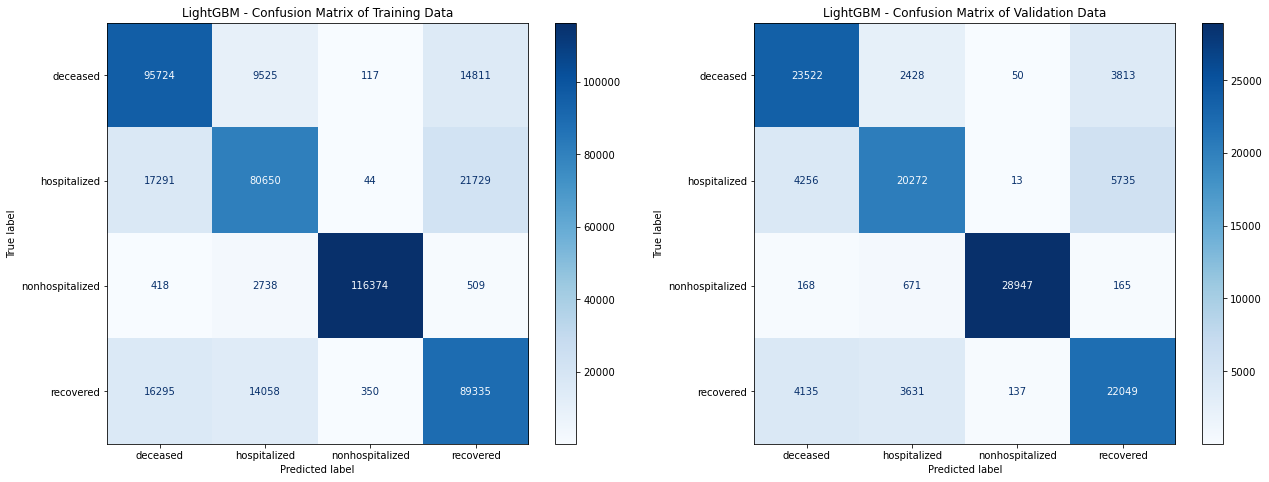

In [20]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(lgbm_model, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('LightGBM - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(lgbm_model, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('LightGBM - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
#fig.savefig('../plots/lgbm_cm.png', bbox_inches='tight', pad_inches=0.3)

### 3.3 Detecting Overfitting
*Plotting the Accuracy measure on a range of the "num_leaves" parameter to detect if the classifier is overfitting.*

In [22]:

leaves = [20,40,60,80,100,120,160,200,240,300]
train_accuracy = np.empty(len(leaves)) 
test_accuracy = np.empty(len(leaves)) 
  
# Loop over K values 
for index, value in enumerate(leaves): 
    lgbm_model = lgb.LGBMClassifier(num_leaves=value)
    lgbm_model.fit(training_data, training_truth, **fit_params)

    training_prediction = lgbm_model.predict(training_data)
    validation_prediction = lgbm_model.predict(validation_data)
    train_accuracy[index] = metrics.accuracy_score(training_prediction, training_truth)
    test_accuracy[index] = metrics.accuracy_score(validation_prediction, validation_truth)

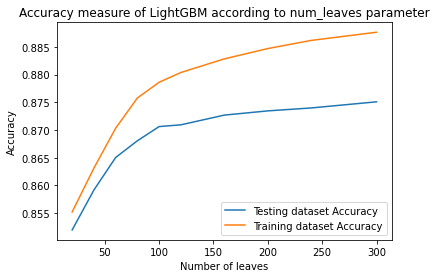

In [23]:
# Generate plot 
plt.plot(leaves, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(leaves, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.title('Accuracy measure of LightGBM according to num_leaves parameter')
plt.xlabel('Number of leaves') 
plt.ylabel('Accuracy') 
plt.savefig('../plots/lgbm_accuracy_curve.png')
plt.show() 

***From what we analyzed by observing the evaluation metrics (confusion matrix & support metric), the class labels of outcome are imbalanced. This could be a major contributing factor in misclassification, and this is something we hope to fix in the next milestone.***